In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error, explained_variance_score
from tqdm import tqdm

# Load the dataset from a CSV file
file_path = 'dataset/main.csv'  # Update the path to your actual file location
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,total_amount,day,hour,trip_duration,trip_distance
0,22.7,0,0,19.800000,1.72
1,22.5,0,0,6.600000,1.80
2,34.3,0,0,17.916667,4.70
3,19.0,0,0,8.300000,1.40
4,19.3,0,0,6.100000,0.80


In [2]:
# Drop rows with any missing values
df.dropna(inplace=True)

In [3]:
# Remove rows with negative fare amounts
df = df[df['total_amount'] >= 0]
len(df)

2929122

In [4]:

# Define a function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for 'trip_distance', 'total_amount', and 'trip_duration'
df = remove_outliers(df, 'trip_distance')
df = remove_outliers(df, 'total_amount')
df = remove_outliers(df, 'trip_duration')

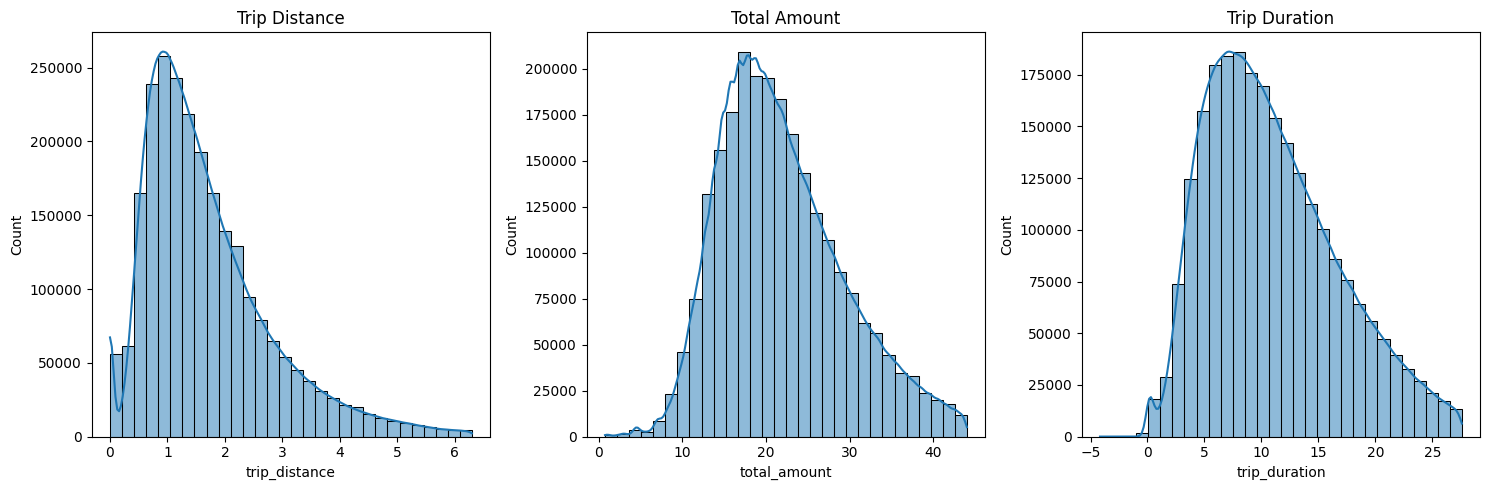

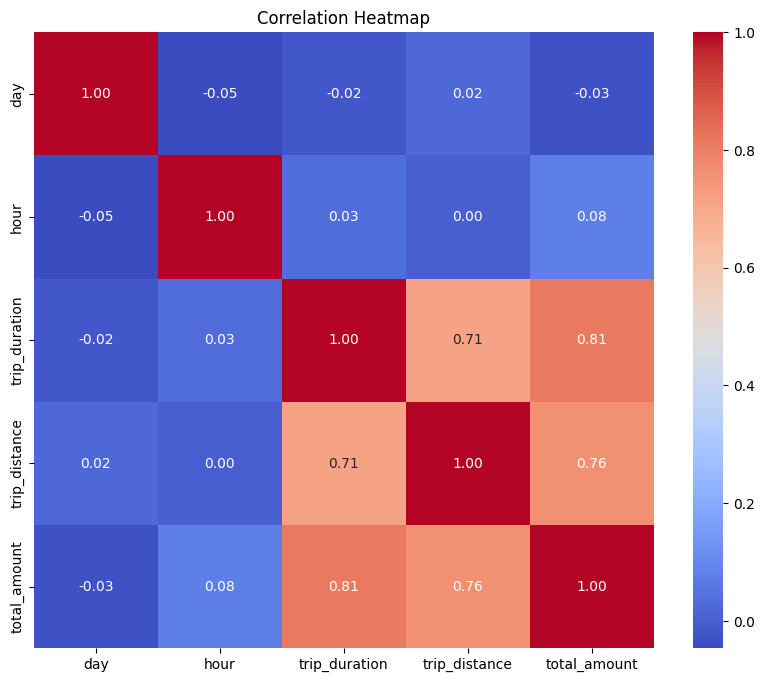

In [5]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['trip_distance'], bins=30, kde=True)
plt.title('Trip Distance')

plt.subplot(1, 3, 2)
sns.histplot(df['total_amount'], bins=30, kde=True)
plt.title('Total Amount')

plt.subplot(1, 3, 3)
sns.histplot(df['trip_duration'], bins=30, kde=True)
plt.title('Trip Duration')

plt.tight_layout()
plt.show()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[['day', 'hour', 'trip_duration', 'trip_distance', 'total_amount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
len(df)

2415876

In [9]:
from sklearn.model_selection import GridSearchCV


n_samples = 1_00_000  # Update this to the desired number of samples

# Ensure the sample size does not exceed the number of available rows
n_samples = min(n_samples, len(df))

# Take a random sample of the cleaned dataset
df = df.sample(n=n_samples, random_state=42)

# Define the features and target variable
features = ['day', 'hour', 'trip_duration', 'trip_distance']
# features = [ 'total_amount']

target = 'total_amount'

standard_deviation = df['total_amount'].std

# Scale the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Define the features (X) and the target variable (y)
X = df[features]
y = df[target]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Progress bar wrapper for model fitting
with tqdm(total=100, desc="Training Random Forest") as pbar:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=30, max_features="log2", bootstrap=False, criterion="squared_error",verbose=Ttue )
    for i in range(1, 101):
        rf_model.n_estimators = i
        rf_model.fit(X_train, y_train)
        pbar.update(1)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"Median AE: {medae}")
print(f"Explained Variance: {explained_variance}")

Training Random Forest:   0%|          | 0/100 [00:00<?, ?it/s]

Training Random Forest: 100%|██████████| 100/100 [07:39<00:00,  4.59s/it]


Mean Absolute Error: 2.973866510271652
Root Mean Squared Error: 3.964256093993682
R²: 0.7117280700354751
MAPE: 0.15932822040424524
Median AE: 2.3544999999999963
Explained Variance: 0.7117426321650151


/home/deep/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


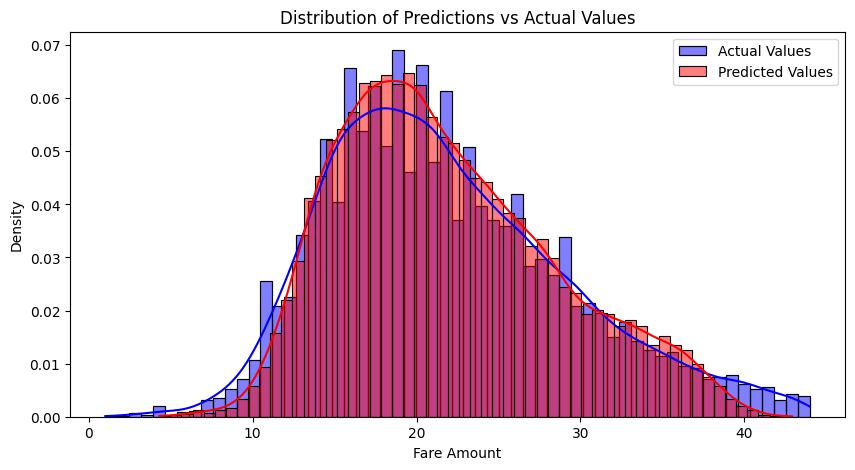

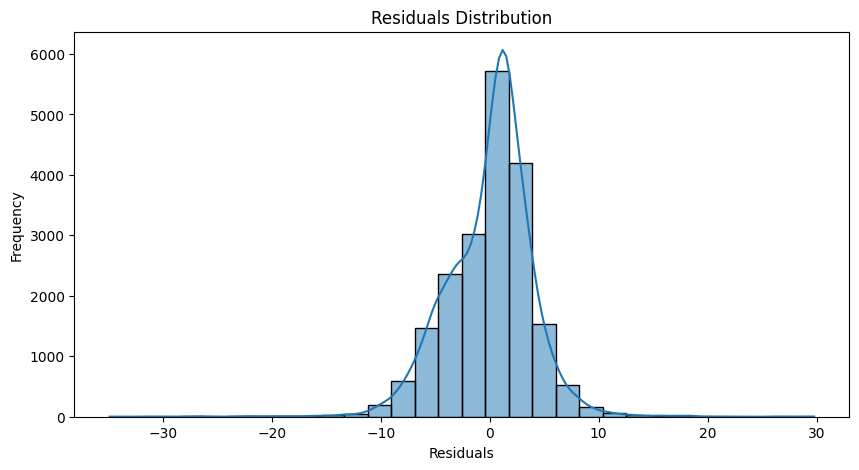

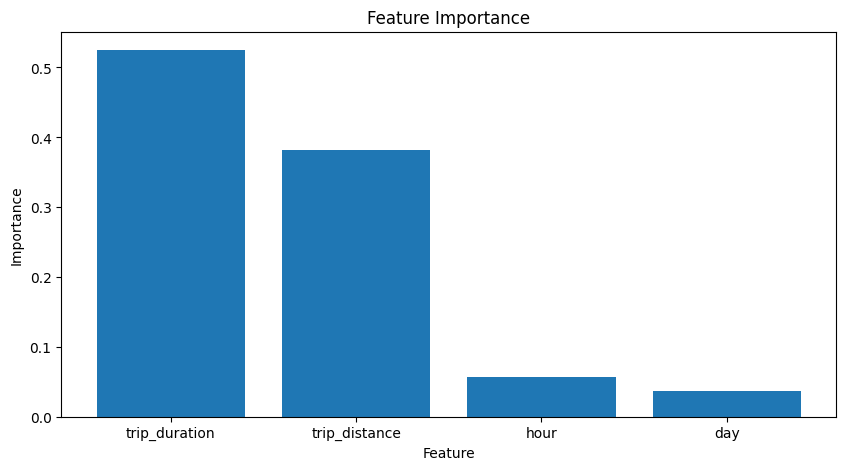

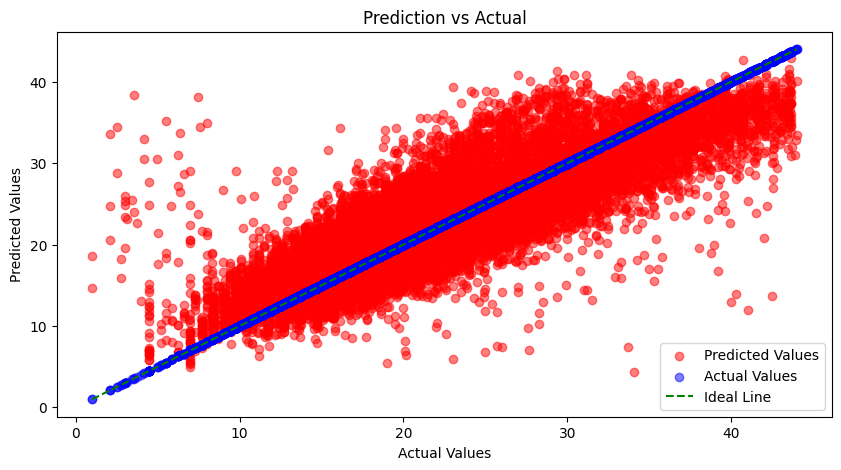

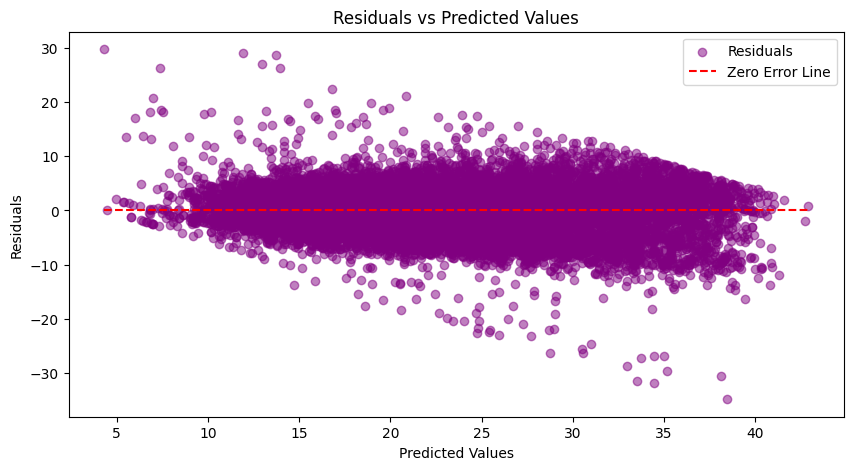

In [10]:
# Plot Distribution of Predictions vs Actual Values
import numpy as np


plt.figure(figsize=(10, 5))
sns.histplot(y_test, color='blue', label='Actual Values', kde=True, stat='density')
sns.histplot(y_pred, color='red', label='Predicted Values', kde=True, stat='density')
plt.title('Distribution of Predictions vs Actual Values')
plt.xlabel('Fare Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Prediction vs Actual Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='red', label='Predicted Values')
plt.scatter(y_test, y_test, alpha=0.5, color='blue', label='Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linestyle='--', label='Ideal Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Residuals vs Predicted Values
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple', label='Residuals')
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red', linestyle='--', label='Zero Error Line')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()
